## Download Data

In [ ]:
!pip install tensorflow==2.8.0

In [1]:
!pip install -U --no-cache-dir gdown --pre
# weather-dataset.zip
!gdown --id 1DYI92Au6-HeaM2ANLDm1cfmVoiFUOn4F

In [ ]:
!unzip weather-dataset.zip

In [2]:
import os 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## Weather Recognition

In [4]:
# list đường dẫn các file ảnh
WEATHER_DATA_PATH = 'dataset'
path_imgs = list(glob.glob(WEATHER_DATA_PATH+'/**/*.jpg'))


In [5]:
# split đường dẫn các file để lấy label cho ảnh và tao thành dataframe để  thống kê
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,sandstorm
1,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,dew
2,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,dew
3,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,fogsmog
4,/home/aivn48/Desktop/DEL/Week25/2022/weather-d...,hail


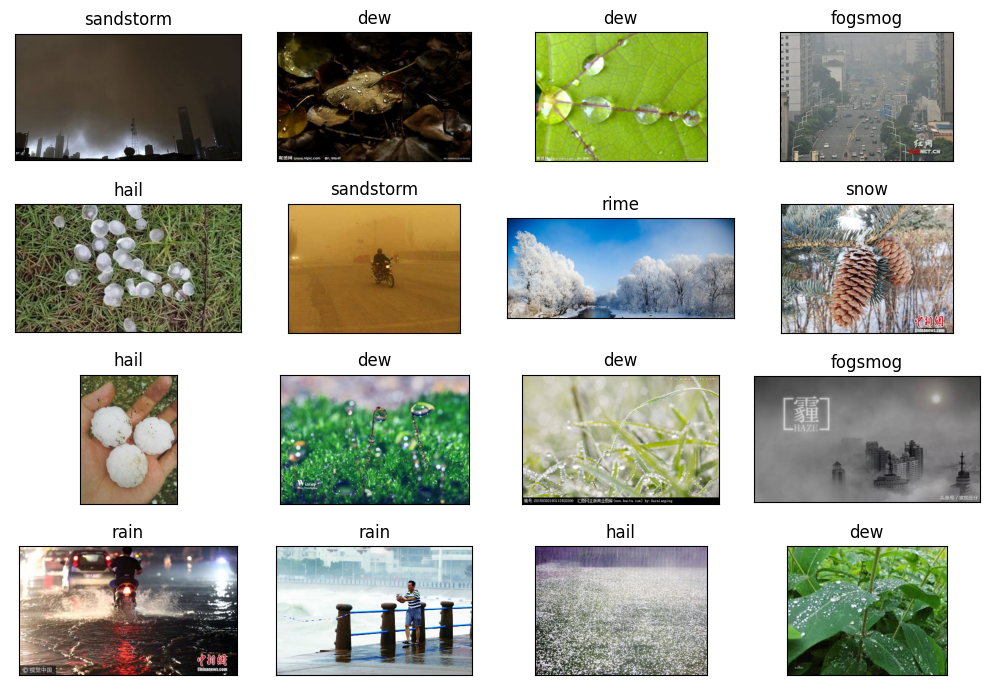

In [6]:
# vẽ các ảnh tương ứng với label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

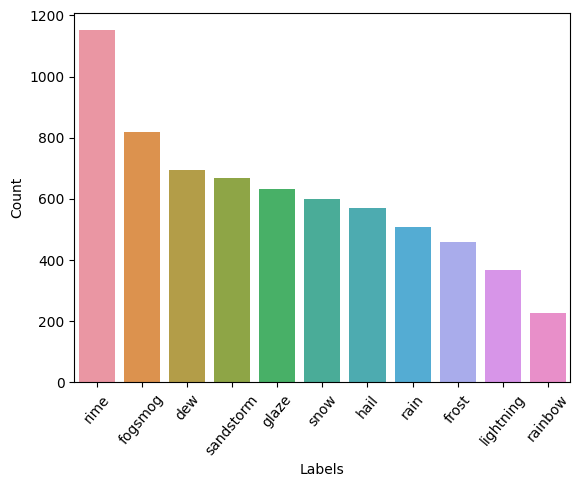

In [7]:
# Thống kê số lượng ảnh cho từng label 
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [8]:
batch_size = 32
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.


2022-12-28 14:53:57.021117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 14:53:57.043520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 14:53:57.043606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 14:53:57.044211: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=WEATHER_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


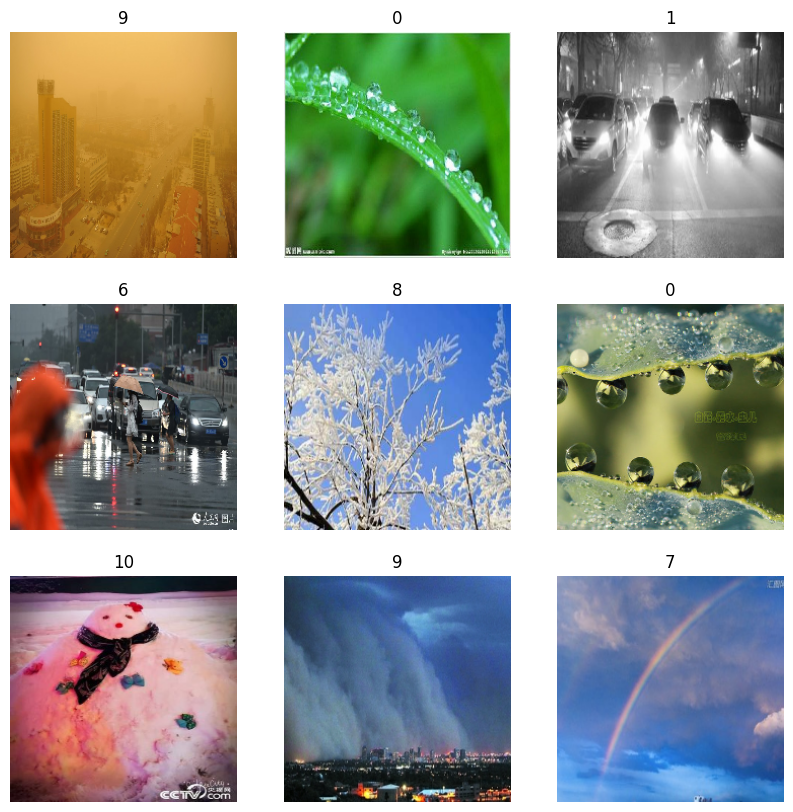

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(scale=1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

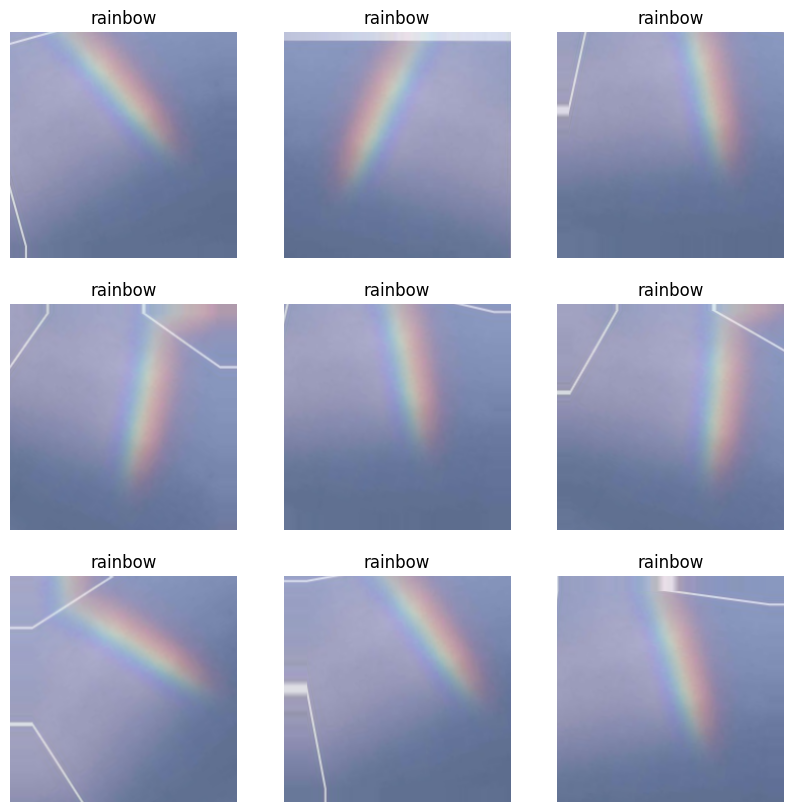

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

## ResNet34_V2 No Skip Connection

In [15]:
class BuildResNet34_v2():
    def __init__(self):
        pass
    
    
    def identity_block(self, inputs, filters):
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        
        return layers.add([inputs, x])
            
        
    
    def projection_block(self, inputs, filters):
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=2, use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        
        
        shortcut = layers.BatchNormalization()(inputs)
        shortcut = layers.Activation('relu')(shortcut)
        shortcut = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same', 
                             strides=2, use_bias=False)(shortcut)
        return layers.add([shortcut,x])
    

    def build_model(self, classes, input_shape=(224,224,3)):
        inputs = layers.Input(shape=input_shape)
        x = layers.ZeroPadding2D(padding=(3,3))(inputs)
        x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, use_bias=False)(x)
        x = layers.ZeroPadding2D(padding=(1,1))(x)
        x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)
        
        # conv2_X
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        
        # conv3_x
        x = self.projection_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        
        # conv4_x
        x = self.projection_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        
        # conv5_x
        x = self.projection_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        
        return model

In [16]:
build_resnet34_v2 = BuildResNet34_v2()
resnet34_v2_model = build_resnet34_v2.build_model(classes=11)

image_input = layers.Input(shape=(img_height,img_width,3))
x = data_augmentation(image_input)
x = resnet34_v2_model(x)
weather_resnet34_v2_model = Model(inputs=image_input, outputs=x)

weather_resnet34_v2_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 11)                21305547  
                                                                 
Total params: 21,305,547
Trainable params: 21,289,419
Non-trainable params: 16,128
_________________________________________________________________


In [17]:
num_epochs = 50

weather_resnet34_v2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


history = weather_resnet34_v2_model.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds)

Epoch 1/50


2022-12-28 14:54:00.976993: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-12-28 14:54:01.819038: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


172/172 [==============================] - 13s 58ms/step - loss: 1.7110 - accuracy: 0.4202 - val_loss: 4.9627 - val_accuracy: 0.1436
Epoch 2/50
172/172 [==============================] - 10s 55ms/step - loss: 1.2464 - accuracy: 0.5792 - val_loss: 2.4854 - val_accuracy: 0.3156
Epoch 3/50
172/172 [==============================] - 10s 55ms/step - loss: 1.1112 - accuracy: 0.6224 - val_loss: 1.2569 - val_accuracy: 0.5561
Epoch 4/50
172/172 [==============================] - 9s 55ms/step - loss: 1.0370 - accuracy: 0.6430 - val_loss: 1.0768 - val_accuracy: 0.6283
Epoch 5/50
172/172 [==============================] - 10s 56ms/step - loss: 0.9843 - accuracy: 0.6630 - val_loss: 1.0428 - val_accuracy: 0.6494
Epoch 6/50
172/172 [==============================] - 10s 56ms/step - loss: 0.9453 - accuracy: 0.6798 - val_loss: 0.9994 - val_accuracy: 0.6603
Epoch 7/50
172/172 [==============================] - 10s 55ms/step - loss: 0.9229 - accuracy: 0.6778 - val_loss: 1.0230 - val_accuracy: 0.6501
Epoc

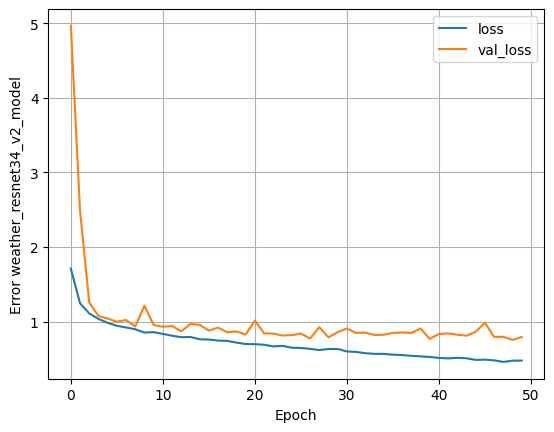

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error weather_resnet34_v2_model')
plt.legend()
plt.grid(True)

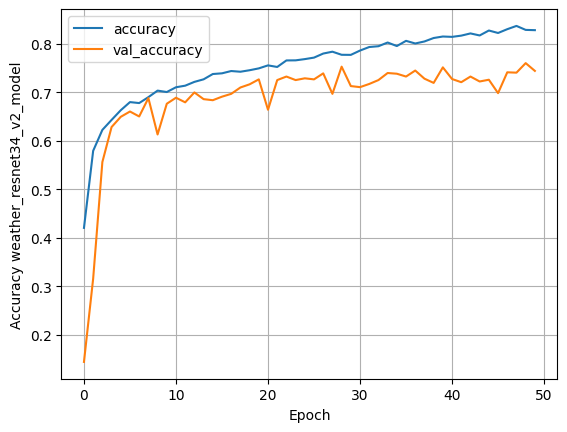

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy weather_resnet34_v2_model')
plt.legend()
plt.grid(True)

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.491488,0.822404,0.985685,0.698251,45
46,0.482053,0.830237,0.796165,0.741254,46
47,0.461058,0.836976,0.798066,0.740525,47
48,0.477319,0.828780,0.755541,0.760204,48
49,0.478941,0.828233,0.795552,0.744169,49
